<a href="https://colab.research.google.com/github/ndb796/Decision-based-Attacks-PyTorch/blob/main/Generate_Determined_Targets_(Correctly_Classified_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <b>Dataset Download</b>

<pre>
<b>Dataset/</b>
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

In [1]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ET1JOEzWfFNInA923UV7Qm8BDxYKaEPTCJXzoHZ1dhjBOA?download=1 -O corrected_facial_identity_latent_vectors.zip
!unzip corrected_facial_identity_latent_vectors.zip -d ./corrected_facial_identity_latent_vectors

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [3]:
# ref: https://chsasank.github.io/vision/_modules/torchvision/datasets/folder.html
from PIL import Image
import os
import os.path
from torch.utils.data import Dataset

EXTENSIONS = [
    '.npy',
]


def is_numpy_file(filename):
    return any(filename.endswith(extension) for extension in EXTENSIONS)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_numpy_file(fname):
                    path = os.path.join(root, fname).split('.npy')[0]
                    item = (path + '.png', path + '.npy', class_to_idx[target])
                    images.append(item)

    return images


def numpy_loader(path):
    return np.load(path)


def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


class LatentFolder(Dataset):
    def __init__(self, root, target_transforms):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx)

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.numpy_loader = numpy_loader
        self.pil_loader = pil_loader
        self.target_transforms = target_transforms

    def __getitem__(self, index):
        img, npy, target = self.imgs[index]
        img = self.pil_loader(img)
        img = self.target_transforms(img)
        npy = self.numpy_loader(npy)
        npy = torch.from_numpy(npy)
        return img, npy, target

    def __len__(self):
        return len(self.imgs)

In [4]:
transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

data_dir = './corrected_facial_identity_latent_vectors/corrected_facial_identity_latent_vectors'

test_dataset = LatentFolder(os.path.join(data_dir), transforms_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
print('Test dataset size:', len(test_dataset))

class_names = test_dataset.classes
print('Class names:', class_names)

Test dataset size: 191
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '223', '226', '228', '230', '

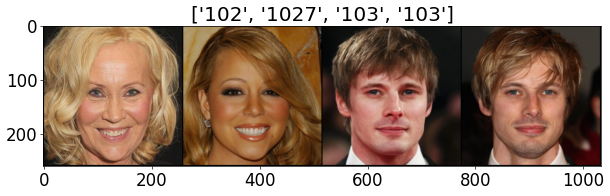

In [5]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(test_dataloader)

# visualize a batch of train image
inputs, npys, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Load Pre-trained Model</b>

In [6]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EeIlxtZtQIdFhRCUkCBSaIQBBbP5dujTUpRNtj8TRinRaQ?download=1 -O facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth

--2021-03-17 16:55:19--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EeIlxtZtQIdFhRCUkCBSaIQBBbP5dujTUpRNtj8TRinRaQ?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FZUlseHRadFFJZEZoUkNVa0NCU2FJUUJCYlA1ZHVqVFVwUk50ajhUUmluUmFRP3J0aW1lPWVLT2JjMlhwMkVn [following]
--2021-03-17 16:55:21--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth?

In [7]:
save_path = 'facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model.load_state_dict(torch.load(save_path))
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# input data normalization class
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [9]:
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    model
).to(device).eval()

### <b>Test Phase</b>

In [10]:
import random

random.seed(0)
np.random.seed(0)

In [11]:
from torchvision.utils import save_image

root_path = './output/'


def make_classes(labels):
    for i in range(labels.shape[0]):
        label_name = class_names[labels[i]]
        if not os.path.exists(root_path + label_name):
            os.makedirs(root_path + label_name)


def save_latents(images, latents, labels, target_images, target_latents, target_labels):
    for i in range(images.shape[0]):
        image = images[i]
        latent = latents[i]
        label_name = class_names[labels[i]]
        target_image = target_images[i]
        target_latent = target_latents[i]
        target_label_name = class_names[target_labels[i]]

        if not os.path.exists(root_path + label_name):
            os.makedirs(root_path + label_name)

        cnt = len(os.listdir(root_path + label_name))
        save_image(image, f'{root_path + label_name}/img{cnt}.ori.png')
        np.save(f'{root_path + label_name}/img{cnt}.ori.npy', latent.cpu())
        save_image(target_image, f'{root_path + label_name}/img{cnt}.trg.png')
        np.save(f'{root_path + label_name}/img{cnt}.trg_{target_label_name}.npy', target_latent.cpu())


for label in os.listdir(data_dir):
    if not os.path.exists(root_path + label):
        os.makedirs(root_path + label)

[Prediction Result Examples]


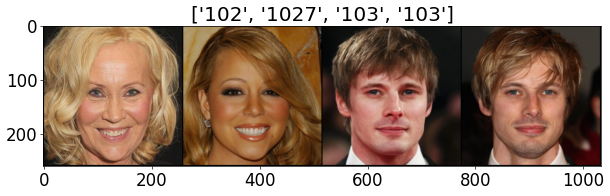

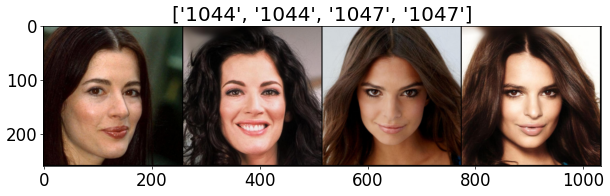

[Test] Loss: 0.0236 Acc: 100.0000% Time: 11.9221s


In [12]:
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, npys, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # generate "random target instances" that are correctly classified.
        target_inputs = torch.zeros_like(inputs).to(device)
        target_npys = torch.zeros_like(npys).to(device)
        target_labels = torch.zeros_like(labels).to(device)
        for k in range(labels.shape[0]):
            target_inputs[k], target_npys[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        outputs = model(target_inputs)
        _, preds = torch.max(outputs, 1)
        while True:
            condition = 0
            idx = torch.tensor([], dtype=torch.long)
            if target_labels.ne(preds).sum() > 0: # to be correctly classified
                idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
                condition += 1
            if target_labels.eq(labels).sum() > 0: # to be different from the original labels
                idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
                condition += 1
            idx = torch.unique(idx)
            if condition == 0:
                break
            for k in list(idx):
                target_inputs[k], target_npys[k], target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
            outputs = model(target_inputs[idx])
            _, preds[idx] = torch.max(outputs, 1)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        save_latents(inputs, npys, labels, target_inputs, target_npys, target_labels)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

#### <b>Final Test Using Generated Dataset</b>

In [13]:
# ref: https://chsasank.github.io/vision/_modules/torchvision/datasets/folder.html
from PIL import Image
import os
import os.path
from torch.utils.data import Dataset


def is_png_file(filename):
    return any(filename.endswith(extension) for extension in ['.png'])


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    global class_to_idx
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    processed = set()
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_png_file(fname):
                    path = os.path.join(root, fname).split('.png')[0][:-4]
                    temp = os.listdir(path.split('img')[0])
                    for di in temp:
                        if 'trg_' in di and 'img' + path.split('img')[1] in di:
                            target_label = di.split('trg_')[1].split('.npy')[0]
                    if path in processed:
                        continue
                    processed.add(path)
                    item = (path + '.ori.png', path + '.ori.npy', class_to_idx[target], path + '.trg.png', path + f'.trg_{target_label}.npy', class_to_idx[target_label])
                    print(item)
                    images.append(item)

    return images


def numpy_loader(path):
    return np.load(path)


def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


class LatentFolder(Dataset):
    def __init__(self, root, target_transforms):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx)

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.numpy_loader = numpy_loader
        self.pil_loader = pil_loader
        self.target_transforms = target_transforms

    def __getitem__(self, index):
        img, npy, label, trg_img, trg_npy, target_label = self.imgs[index]
        img = self.pil_loader(img)
        img = self.target_transforms(img)
        trg_img = self.pil_loader(trg_img)
        trg_img = self.target_transforms(trg_img)
        npy = self.numpy_loader(npy)
        npy = torch.from_numpy(npy)
        trg_npy = self.numpy_loader(trg_npy)
        trg_npy = torch.from_numpy(trg_npy)
        return img, npy, label, trg_img, trg_npy, target_label

    def __len__(self):
        return len(self.imgs)

In [14]:
transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

data_dir = './output'

test_dataset = LatentFolder(os.path.join(data_dir), transforms_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
print('Test dataset size:', len(test_dataset))

class_names = test_dataset.classes
print('Class names:', class_names)

('./output/102/img0.ori.png', './output/102/img0.ori.npy', 0, './output/102/img0.trg.png', './output/102/img0.trg_321.npy', 154)
('./output/1027/img0.ori.png', './output/1027/img0.ori.npy', 1, './output/1027/img0.trg.png', './output/1027/img0.trg_34.npy', 162)
('./output/103/img0.ori.png', './output/103/img0.ori.npy', 2, './output/103/img0.trg.png', './output/103/img0.trg_1077.npy', 10)
('./output/103/img4.ori.png', './output/103/img4.ori.npy', 2, './output/103/img4.trg.png', './output/103/img4.trg_204.npy', 110)
('./output/1044/img0.ori.png', './output/1044/img0.ori.npy', 6, './output/1044/img0.trg.png', './output/1044/img0.trg_5.npy', 204)
('./output/1044/img4.ori.png', './output/1044/img4.ori.npy', 6, './output/1044/img4.trg.png', './output/1044/img4.trg_458.npy', 194)
('./output/1047/img0.ori.png', './output/1047/img0.ori.npy', 7, './output/1047/img0.trg.png', './output/1047/img0.trg_334.npy', 159)
('./output/1047/img4.ori.png', './output/1047/img4.ori.npy', 7, './output/1047/img4.

[Prediction Result Examples]


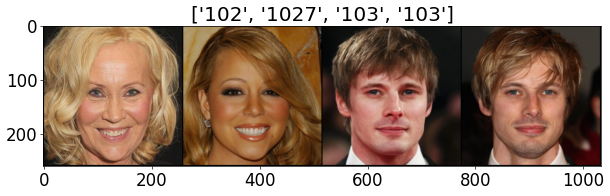

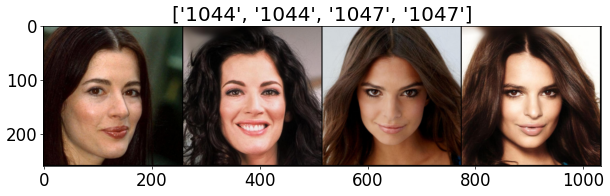

[Test] Loss: 0.0236 Acc: 100.0000% Time: 1.8563s


In [15]:
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, npys, labels, target_inputs, target_npys, target_labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

[Prediction Result Examples]


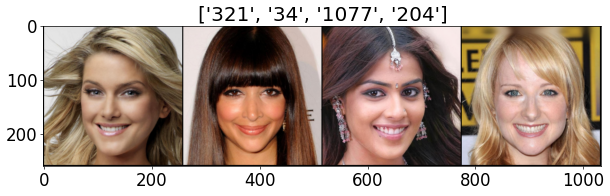

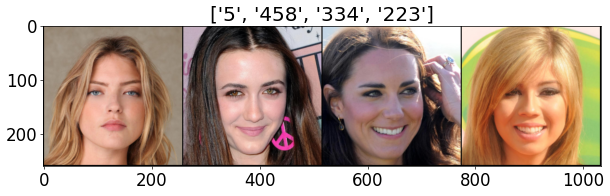

[Test] Loss: 0.0173 Acc: 100.0000% Time: 1.9785s


In [16]:
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, npys, labels, target_inputs, target_npys, target_labels) in enumerate(test_dataloader):
        target_inputs = target_inputs.to(device)
        target_labels = target_labels.to(device)

        outputs = model(target_inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, target_labels)

        running_loss += loss.item() * target_inputs.size(0)
        running_corrects += torch.sum(preds == target_labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(target_inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in target_labels[:4]])
            images = torchvision.utils.make_grid(target_inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in target_labels[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

In [17]:
!mv ./output/ ./determined_corrected_facial_identity_latent_vectors/
!zip -r determined_corrected_facial_identity_latent_vectors.zip ./determined_corrected_facial_identity_latent_vectors/*

  adding: determined_corrected_facial_identity_latent_vectors/102/ (stored 0%)
  adding: determined_corrected_facial_identity_latent_vectors/102/img0.ori.npy (deflated 94%)
  adding: determined_corrected_facial_identity_latent_vectors/102/img0.trg.png (deflated 0%)
  adding: determined_corrected_facial_identity_latent_vectors/102/img0.ori.png (deflated 0%)
  adding: determined_corrected_facial_identity_latent_vectors/102/img0.trg_321.npy (deflated 94%)
  adding: determined_corrected_facial_identity_latent_vectors/1027/ (stored 0%)
  adding: determined_corrected_facial_identity_latent_vectors/1027/img0.ori.npy (deflated 94%)
  adding: determined_corrected_facial_identity_latent_vectors/1027/img0.trg.png (deflated 0%)
  adding: determined_corrected_facial_identity_latent_vectors/1027/img0.ori.png (deflated 0%)
  adding: determined_corrected_facial_identity_latent_vectors/1027/img0.trg_34.npy (deflated 94%)
  adding: determined_corrected_facial_identity_latent_vectors/103/ (stored 0%)
  a